In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

sns.set_style('darkgrid')
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
pd.set_option('display.max_rows',2000)

%run ../shared_datasets/charlie_functions.py
%run ../shared_datasets/clean_dataframe.py

In [2]:
raw_data = pd.read_csv('/Users/schlinkertc/Flatiron/projects/mod4_project/developer_survey_2019/survey_results_public.csv')

dataframe_class = CleanDataframe(raw_data)
df = dataframe_class.cleaned_df

## Regression using OLS

After setting our X and Y variables, we're ready to being our linear regression. The sm_OLS fucntion, defined in 'charlie_functions.py', uses statsmodels.api.LinearRegression() 

- First we solve for the ordinary least squares regression and return performance metrics, coefficient values, and predicted vs observed outcomes.
- Next, the recursive ols function will run the regression, elimnate any coeffecients with a p-value above .05, and run the regression again. 
    - This will repeat until all coefficients have an an acceptable p-value.

In [3]:
raw_data = pd.read_csv('/Users/schlinkertc/Flatiron/projects/mod4_project/developer_survey_2019/survey_results_public.csv')

dataframe_class = CleanDataframe(raw_data)
df = dataframe_class.cleaned_df

In [4]:
# set X and Y
X = df.drop(columns=['Respondent','ConvertedComp'])
Y = df['ConvertedComp']

In [5]:
X_train , X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=12)

In [6]:
sm_performance,sm_variables,sm_outcomes = sm_OLS(X_train,y_train)

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [7]:
# make a deep copy of our X values for the recursive function
X_recursive = pd.DataFrame.copy(X,deep=True)

In [8]:
recursive_performance,recursive_variables,recursive_outcomes = ols_recursion(X_recursive,Y)

predictors used:  288
Predictors to drop:  140
Running regression with new subset of predictors...
predictors used:  148
Predictors to drop:  22
Running regression with new subset of predictors...
predictors used:  126
Predictors to drop:  4
Running regression with new subset of predictors...
predictors used:  122
Predictors to drop:  4
Running regression with new subset of predictors...
predictors used:  118
Predictors to drop:  0
Complete. No coefficients with P-value greater than .05 remain


By eliminating predictors with p-values above .05 recursively, we've cut our number of variables down from 294 to 118. Eliminating these variables had very little effect on our regression performance. 

In [9]:
comparison = pd.concat((sm_performance.transpose(),recursive_performance.transpose()),ignore_index=True)
comparison.index = ['288 predictors','118 predictors']
comparison

,MSE,MSE_resid,RMSE,R^2,R^2_adjusted,F-stat,AIC,BIC
288 predictors,8.378591e+10,8.386588e+08,28959.607115,0.631943,0.625618,99.904641,349064.348073,350989.726078
118 predictors,2.265275e+11,8.447759e+08,29065.028305,0.624651,0.622321,268.151008,436291.427705,437200.100589


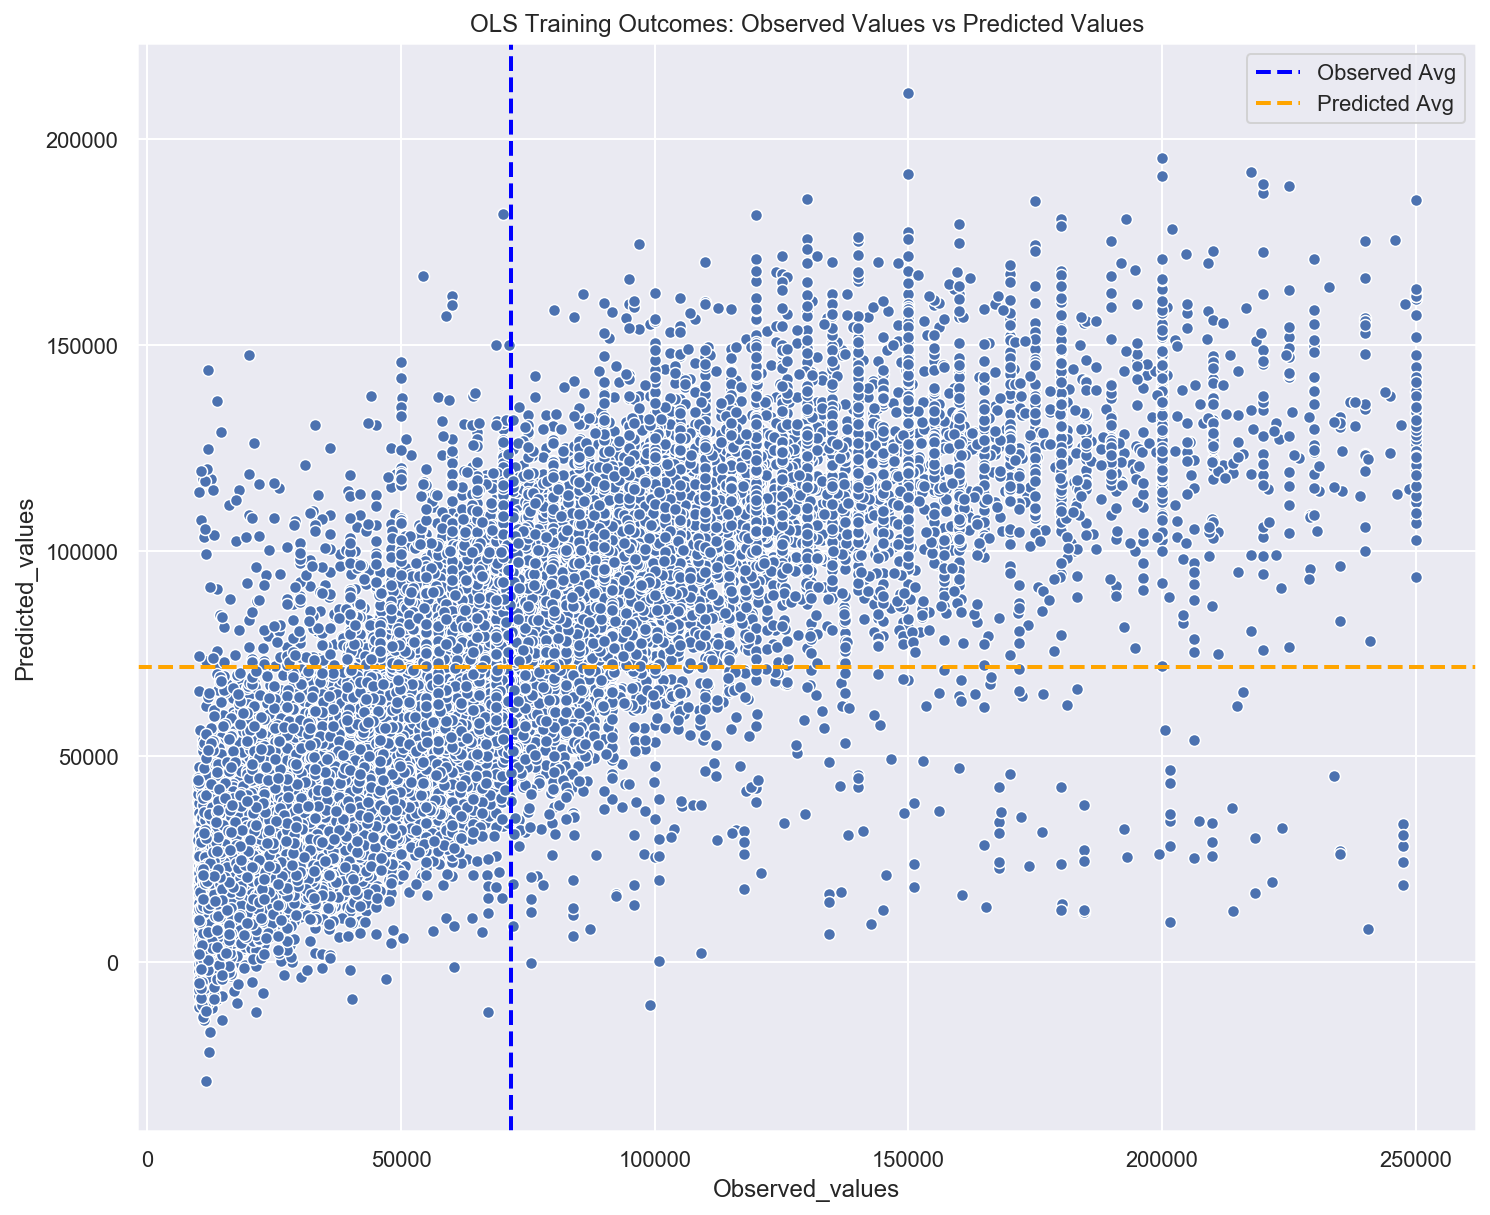

In [10]:
sns.set(rc={'figure.figsize':(12,10)})

sns.scatterplot(x=recursive_outcomes['Observed_values'],y=recursive_outcomes['Predicted_values'])
plt.axvline(recursive_outcomes['Observed_values'].mean(),color='blue', linestyle='--', lw=2,label='Observed Avg')
plt.axhline(recursive_outcomes['Predicted_values'].mean(),color='orange', linestyle='--', lw=2,label='Predicted Avg')

plt.title("OLS Training Outcomes: Observed Values vs Predicted Values")
plt.legend()


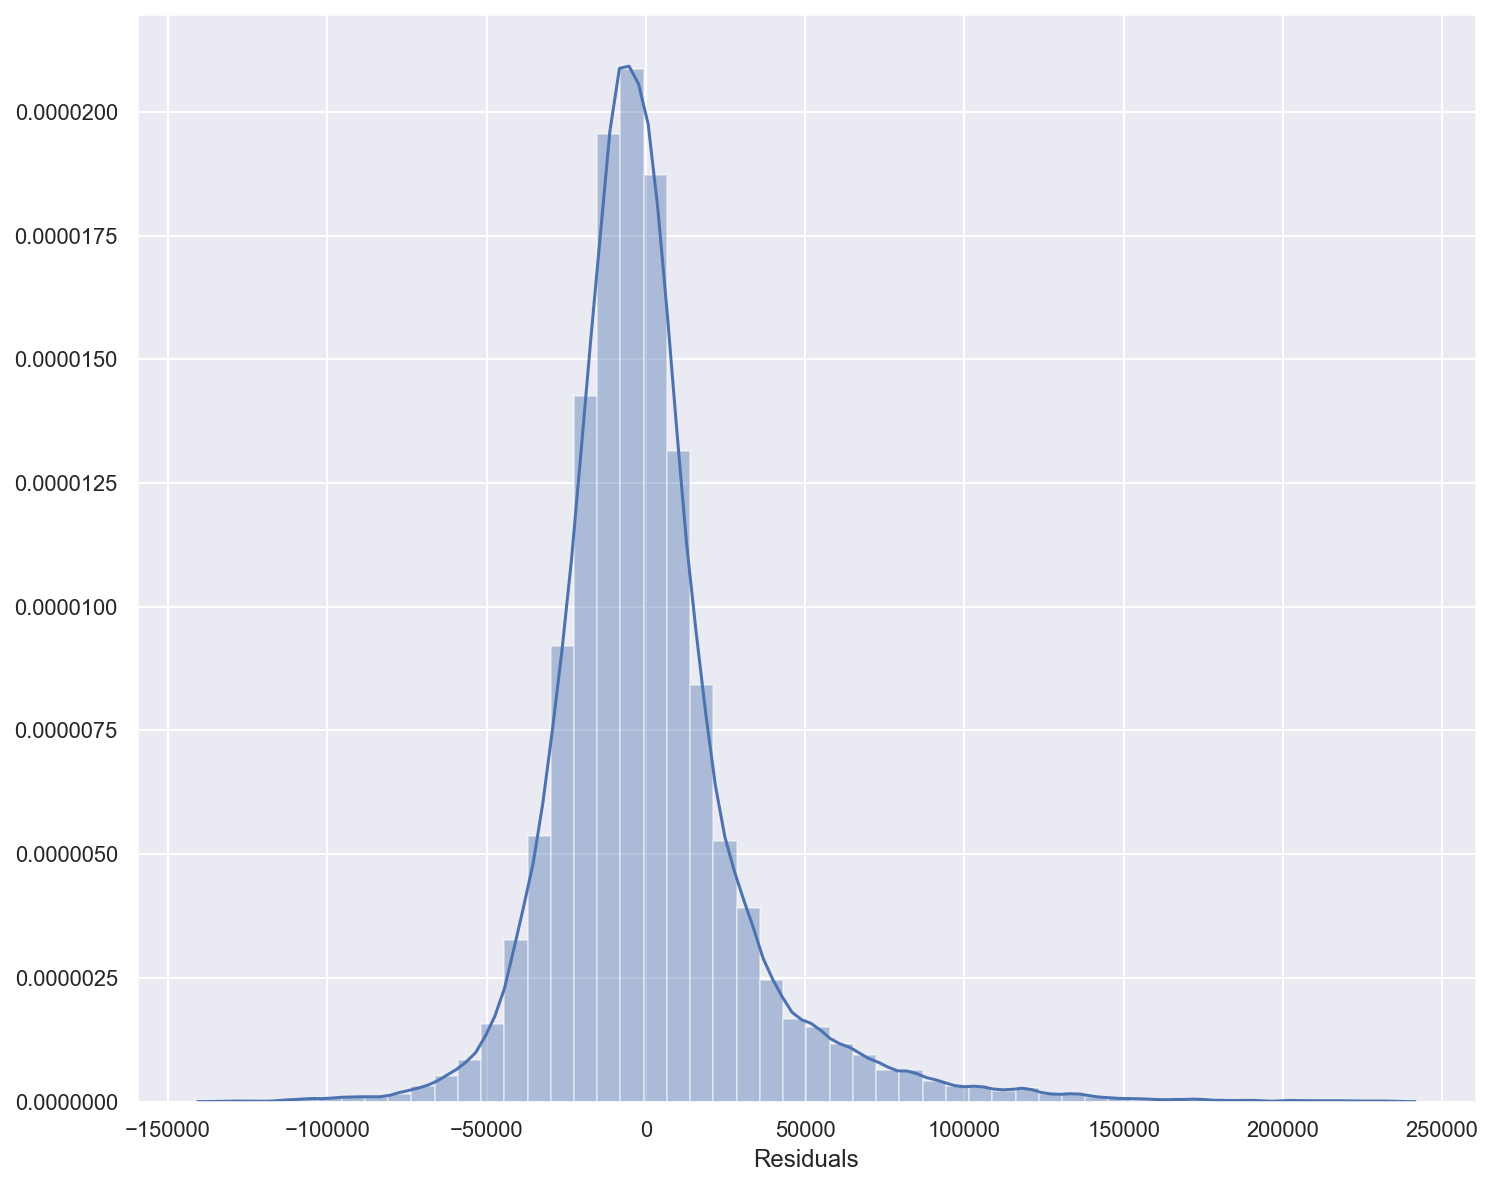

In [11]:
# Check residuals for normality
sns.distplot(recursive_outcomes['Residuals'])

## Log transform our Y-variable

According to University of Virginia: 
- "Log transformations are often recommended for skewed data, such as monetary measures or certain biological and demographic measures. Log transforming data usually has the effect of spreading out clumps of data and bringing together spread-out data." 

- We can't log-transform our predictors because we have dummy variables

- rules for interpretation when the outcome is transformed: 
    - Exponentiate the coefficient, subtract one from this number, and multiply by 100. This gives the percent increase (or decrease) in the response for every one-unit increase in the independent variable. Example: the coefficient is 0.198. (exp(0.198) – 1) * 100 = 21.9. For every one-unit increase in the independent variable, our dependent variable increases by about 22%.

In [21]:
X_train_recursive = X_train[X_recursive.columns.tolist()]

In [22]:
log_performance, log_variables, log_outcomes = sm_OLS(X_train_recursive,np.log(y_train))

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [23]:
log_performance = log_performance.transpose()
log_performance.index=['118 predictors, log transformed']

In [24]:
comparison = comparison.append(log_performance)
comparison

,MSE,MSE_resid,RMSE,R^2,R^2_adjusted,F-stat,AIC,BIC
288 predictors,8.378591e+10,8.386588e+08,28959.607115,0.631943,0.625618,99.904641,349064.348073,350989.726078
118 predictors,2.265275e+11,8.447759e+08,29065.028305,0.624651,0.622321,268.151008,436291.427705,437200.100589
"118 predictors, log transformed",4.903100e+01,1.599856e-01,0.399982,0.704261,0.701963,306.471266,15109.196028,15991.978038


### Investigating Multicollinearity


In [186]:
def investigate_multicollinearity(predictors):
    X = df[predictors]
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(f"VIF: {len(vif)} columns compared")
    return list(zip(predictors, vif)), vif, predictors

In [187]:
list_vif, vif, x_keep = investigate_multicollinearity(X_recursive.columns.tolist())
# list_vif

//anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF: 117 columns compared


In [189]:
list_vif

[('WorkWeekHrs', 1.1100141682948108),
 ('YearsCode', 7.505189618043502),
 ('CodeRevHrs', 1.0658122327983113),
 ('YearsCodePro', 6.687649025638639),
 ('learned_code', 1.4084641162229683),
 ('Bash/Shell/PowerShell', 1.0828107884285458),
 ('C#', 1.2348307848502242),
 ('F#', 1.0286260596373933),
 ('Go', 1.0563293411945756),
 ('HTML/CSS', 1.21353562761776),
 ('Other(s):', 1.032403424897695),
 ('PHP', 1.147551186135163),
 ('Ruby', 1.085260622732938),
 ('Scala', 1.0326534807890795),
 ('TypeScript', 1.123251728597275),
 ('VBA', 1.0521911901861174),
 ('East Asian', 1.3099910075797176),
 ('Native American, Pacific Islander, or Indigenous Australian',
  1.0117634912787867),
 ('South Asian', 2.565388112707698),
 ('White or of European descent', 2.247023108987042),
 ('OrgSize_1,000 to 4,999 employees', 1.2714712974388718),
 ('OrgSize_10 to 19 employees', 1.2280572144575672),
 ('OrgSize_10,000 or more employees', 1.3607617282544804),
 ('OrgSize_2-9 employees', 1.278695313751698),
 ('OrgSize_20 to 99

In [207]:
def remove_vif_scores_greater_than_5(x_column_keep, vif):
    vif_scores = list(zip(x_column_keep, vif))
    x_keep = [x for x,vif in vif_scores if vif < 5]
    x_drop = [x for x,vif in vif_scores if vif > 5]
    print(f"Variance Inflation Factor (VIF): {len(vif_scores)} | To Keep: {len(x_keep)} | To Drop: {len(x_drop)}")
    return x_keep, x_drop

In [208]:
x_keep, x_drop = remove_vif_scores_greater_than_5(x_keep, vif)

Variance Inflation Factor (VIF): 117 | To Keep: 107 | To Drop: 10


In [209]:
x_keep

['WorkWeekHrs',
 'CodeRevHrs',
 'learned_code',
 'Bash/Shell/PowerShell',
 'C#',
 'F#',
 'Go',
 'HTML/CSS',
 'Other(s):',
 'PHP',
 'Ruby',
 'Scala',
 'TypeScript',
 'VBA',
 'East Asian',
 'Native American, Pacific Islander, or Indigenous Australian',
 'South Asian',
 'White or of European descent',
 'OrgSize_1,000 to 4,999 employees',
 'OrgSize_10 to 19 employees',
 'OrgSize_10,000 or more employees',
 'OrgSize_2-9 employees',
 'OrgSize_20 to 99 employees',
 'OrgSize_5,000 to 9,999 employees',
 'OrgSize_Just me - I am a freelancer, sole proprietor, etc.',
 'Country_Australia',
 'Country_Austria',
 'Country_Belarus',
 'Country_Belgium',
 'Country_Bulgaria',
 'Country_Canada',
 'Country_Croatia',
 'Country_Cyprus',
 'Country_Czech Republic',
 'Country_Denmark',
 'Country_Egypt',
 'Country_Finland',
 'Country_Germany',
 'Country_Greece',
 'Country_Hong Kong (S.A.R.)',
 'Country_Hungary',
 'Country_Iceland',
 'Country_India',
 'Country_Indonesia',
 'Country_Ireland',
 'Country_Israel',
 'C

In [214]:
vif_performance, vif_variables, vif_outcomes = sm_OLS(X_train[x_keep],np.log(y_train))

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [215]:
vif_performance = vif_performance.transpose()
vif_performance.index=['Multicolinearity Removed']

comparison = comparison.append(vif_performance)
comparison

,MSE,MSE_resid,RMSE,R^2,R^2_adjusted,F-stat,AIC,BIC
288 predictors,8.378591e+10,8.386588e+08,28959.607115,0.631943,0.625618,99.904641,349064.348073,350989.726078
118 predictors,2.265275e+11,8.447759e+08,29065.028305,0.624651,0.622321,268.151008,436291.427705,437200.100589
"118 predictors, log transformed",4.903100e+01,1.599856e-01,0.399982,0.704261,0.701963,306.471266,15109.196028,15991.978038
Multicolinearity Removed,3.256676e+01,3.053558e-01,0.552590,0.435235,0.431154,106.651870,24742.863231,25564.763723
Multicolinearity Removed,3.256676e+01,3.053558e-01,0.552590,0.435235,0.431154,106.651870,24742.863231,25564.763723


### To Recap:

We ran a regression with 294 predictors. Then, we got rid of any predictors that had unacceptably high p-values. We did so recursively. Eliminating those variables decreased our R^2 very slightly. Finally, we log-transformed our outcome variable, and our R^2 went up to 70%. Now, we're going to attempt to train a model using cross-validation and regularization.  

## Regularization and Cross-Validation

This function splits the data into training and test sets for cross validation. In addition to X and Y values, it takes in the name of the model to use and the alpha value. It returns the predictor coefficients and the training/test R^2

In [31]:
def regularization(x_values,y_values,alpha_val,Model):
    scale = MinMaxScaler()
    transformed = scale.fit_transform(x_values)
    
    X_transformed = pd.DataFrame(transformed, columns = x_values.columns)
    
    X_train , X_test, y_train, y_test = train_test_split(X_transformed, y_values, test_size=0.2, random_state=12)
    
    if Model == LinearRegression:
        #OLS doesn't use an alpha
        model = Model()
    else:
        model = Model(alpha=alpha_val)
        
    model.fit(X_train, y_train)    
    
    variables = pd.DataFrame(model.coef_,index=x_values.columns,columns=['Coefficients'])
    intercept = pd.DataFrame.from_dict({'Intercept':model.intercept_},orient='index',columns=['Coefficients'])
    
    performance = {'Train':model.score(X_train,y_train),'Test':model.score(X_test,y_test)}
    
    # create predictions
    if Model == Lasso:
        y_h_train = np.reshape(model.predict(X_train),(X_train.shape[0],1))
        y_h_test = np.reshape(model.predict(X_test),(X_test.shape[0],1))
        y_h_test = [item for sublist in y_h_test for item in sublist]
    else:
        y_h_train = model.predict(X_train)
        y_h_test = model.predict(X_test)
    
    outcomes = pd.DataFrame({'Observed':y_test,'Predicted':y_h_test})
    outcomes['Residuals'] = (outcomes['Observed']-outcomes['Predicted'])**2
    
    return variables.append(intercept),performance, outcomes
    

In [32]:
#we'll use this function to test different Alpha values 
optimal_alphas = {}
def optimal_alpha(start,stop,steps,Model,chart_title,x_values,y_values):
    test_R_squared = []
    alpha = []
    for i in np.linspace(start,stop,num=steps):
        #print('Alpha: ',i,'Test R^2: ',regularization(Xtemp,Ytemp,i,Lasso)[1]['Test'],sep='\n')
        alpha.append(i)
        test_R_squared.append(regularization(x_values,y_values,i,Model)[1]['Test'])
    sns.lineplot(alpha,test_R_squared)
    plt.xlabel('Alpha')
    plt.ylabel('Test R^2')
    plt.title('{} Regression: Test R^2 for Increasing Alpha Value'.format(chart_title))
    plt.axhline(max(test_R_squared),linestyle='--',label='Alpha: {},R^2: {}'.format(alpha[test_R_squared.index(max(test_R_squared))],max(test_R_squared)))
    plt.legend()
    
    optimal_alphas[chart_title]=alpha[test_R_squared.index(max(test_R_squared))]
    

In [185]:
x_drop

['YearsCode',
 'YearsCodePro',
 'Country_United States',
 'Student_No',
 'Student_Yes, full-time',
 'Student_Yes, part-time',
 'CompFreq_Monthly',
 'CompFreq_Weekly',
 'CompFreq_Yearly',
 'Continent_Europe']

### Lasso 

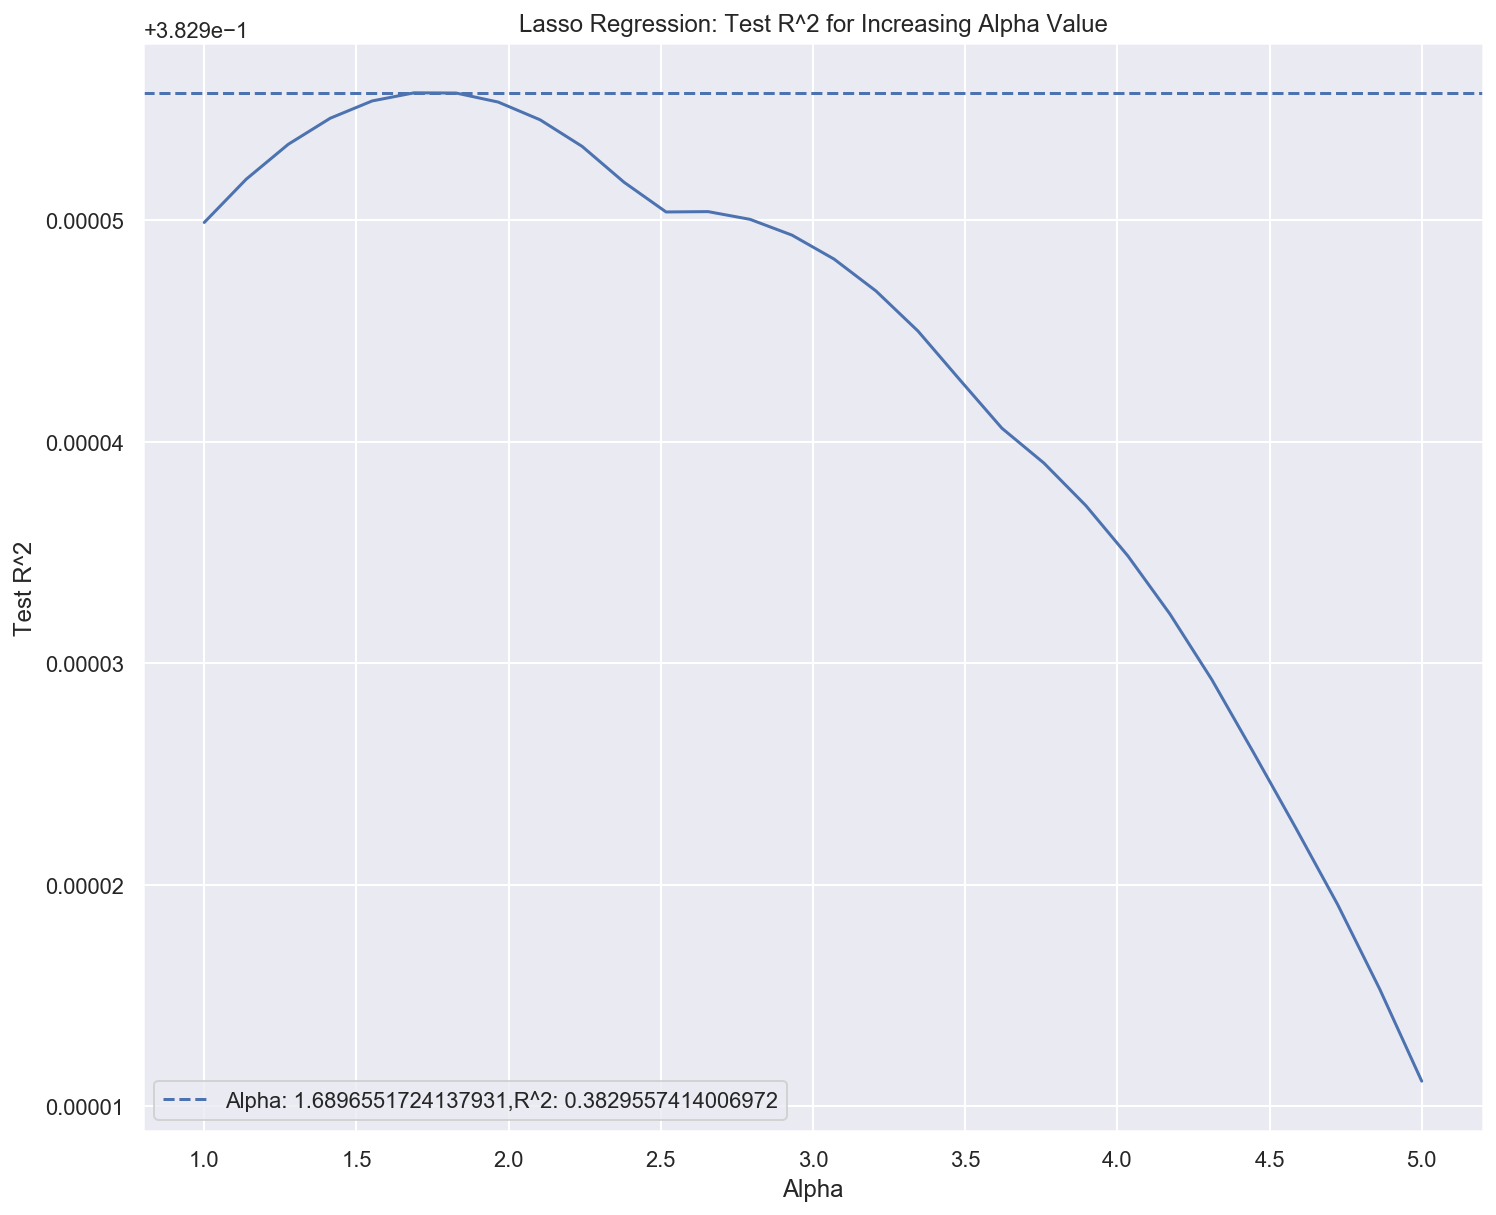

In [184]:
optimal_alpha(1,5,30,Lasso,'Lasso',X[x_keep],Y)

In [34]:
optimal_alphas

{'Lasso': 10.551724137931036}

In [35]:
# run the lasso regression using the optimal alpha value that we found.
lasso_variables,lasso_performance,lasso_outcomes = regularization(X,Y,optimal_alphas['Lasso'],Lasso)

In [36]:
# R^2 values for training and test data
lasso_performance

{'Train': 0.6280095513209414, 'Test': 0.6224074622343361}

In [37]:
lasso_outcomes

,Observed,Predicted,Residuals
67982,28800.0,19400.567857,8.834932e+07
50880,23460.0,36588.594021,1.723600e+08
15407,64115.0,74480.603030,1.074457e+08
23344,37500.0,67900.400495,9.241844e+08
21976,60000.0,66073.179076,3.688350e+07
...,...,...,...
59878,32064.0,35539.424701,1.207858e+07
3332,36091.0,51260.991948,2.301287e+08
15591,40000.0,79481.346399,1.558777e+09
35694,109912.0,64242.660654,2.085689e+09


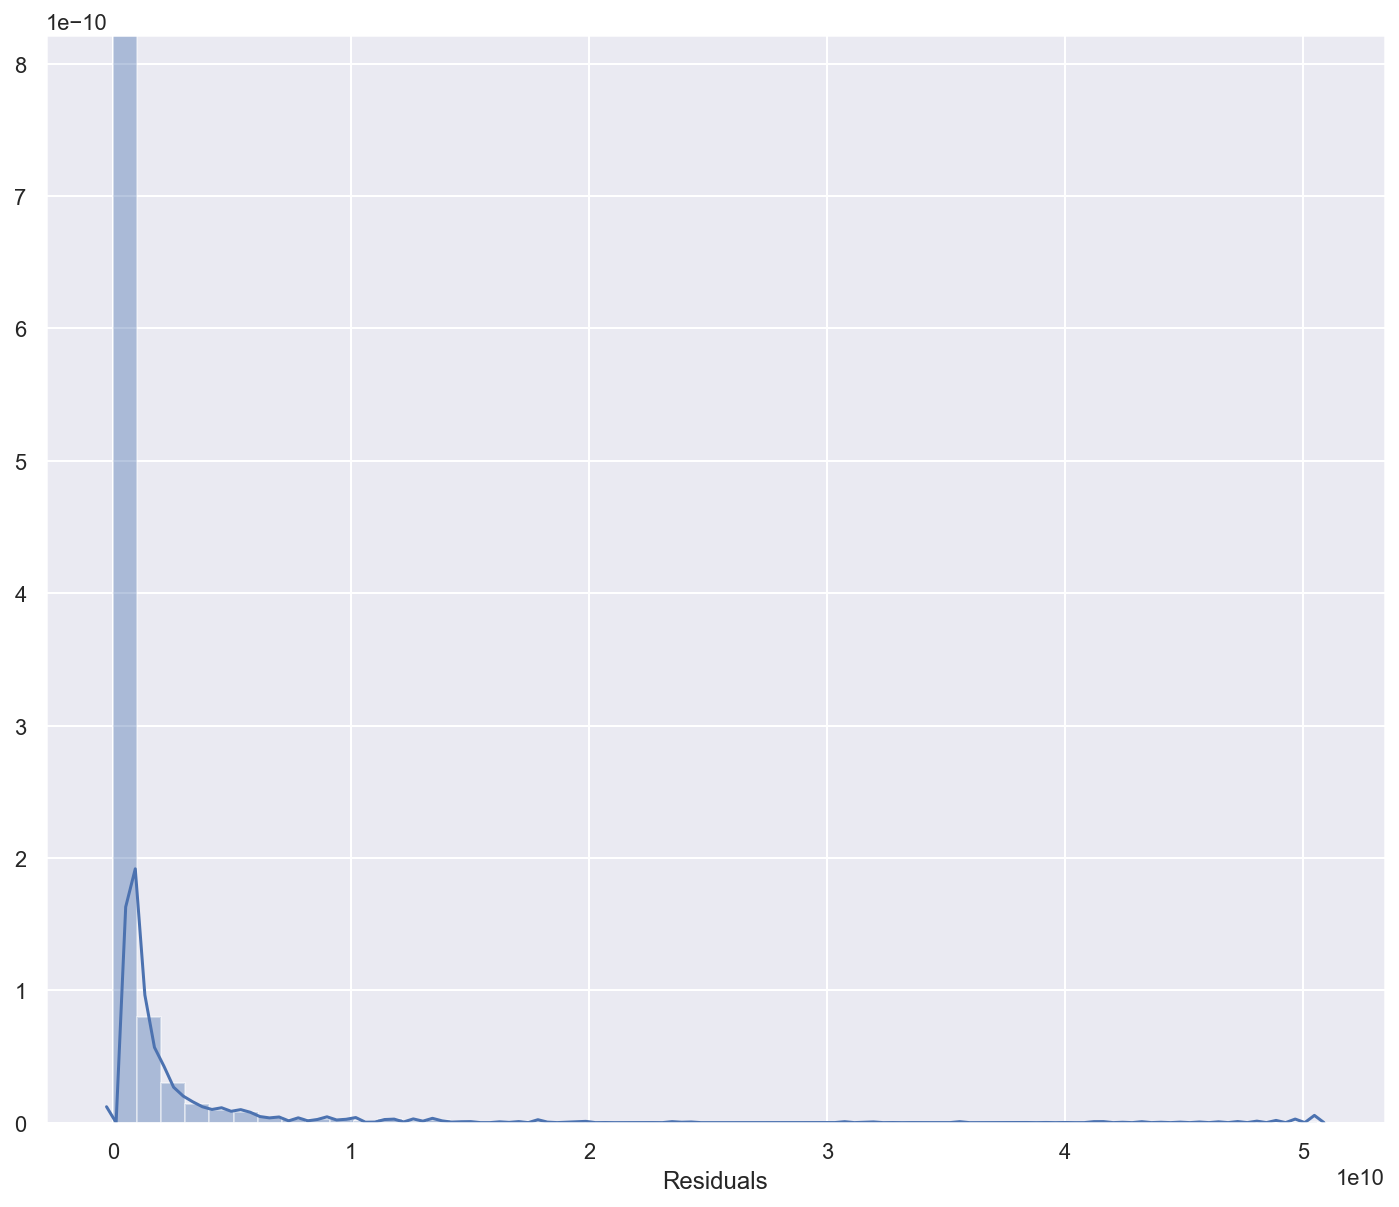

In [38]:
sns.distplot(lasso_outcomes['Residuals'])

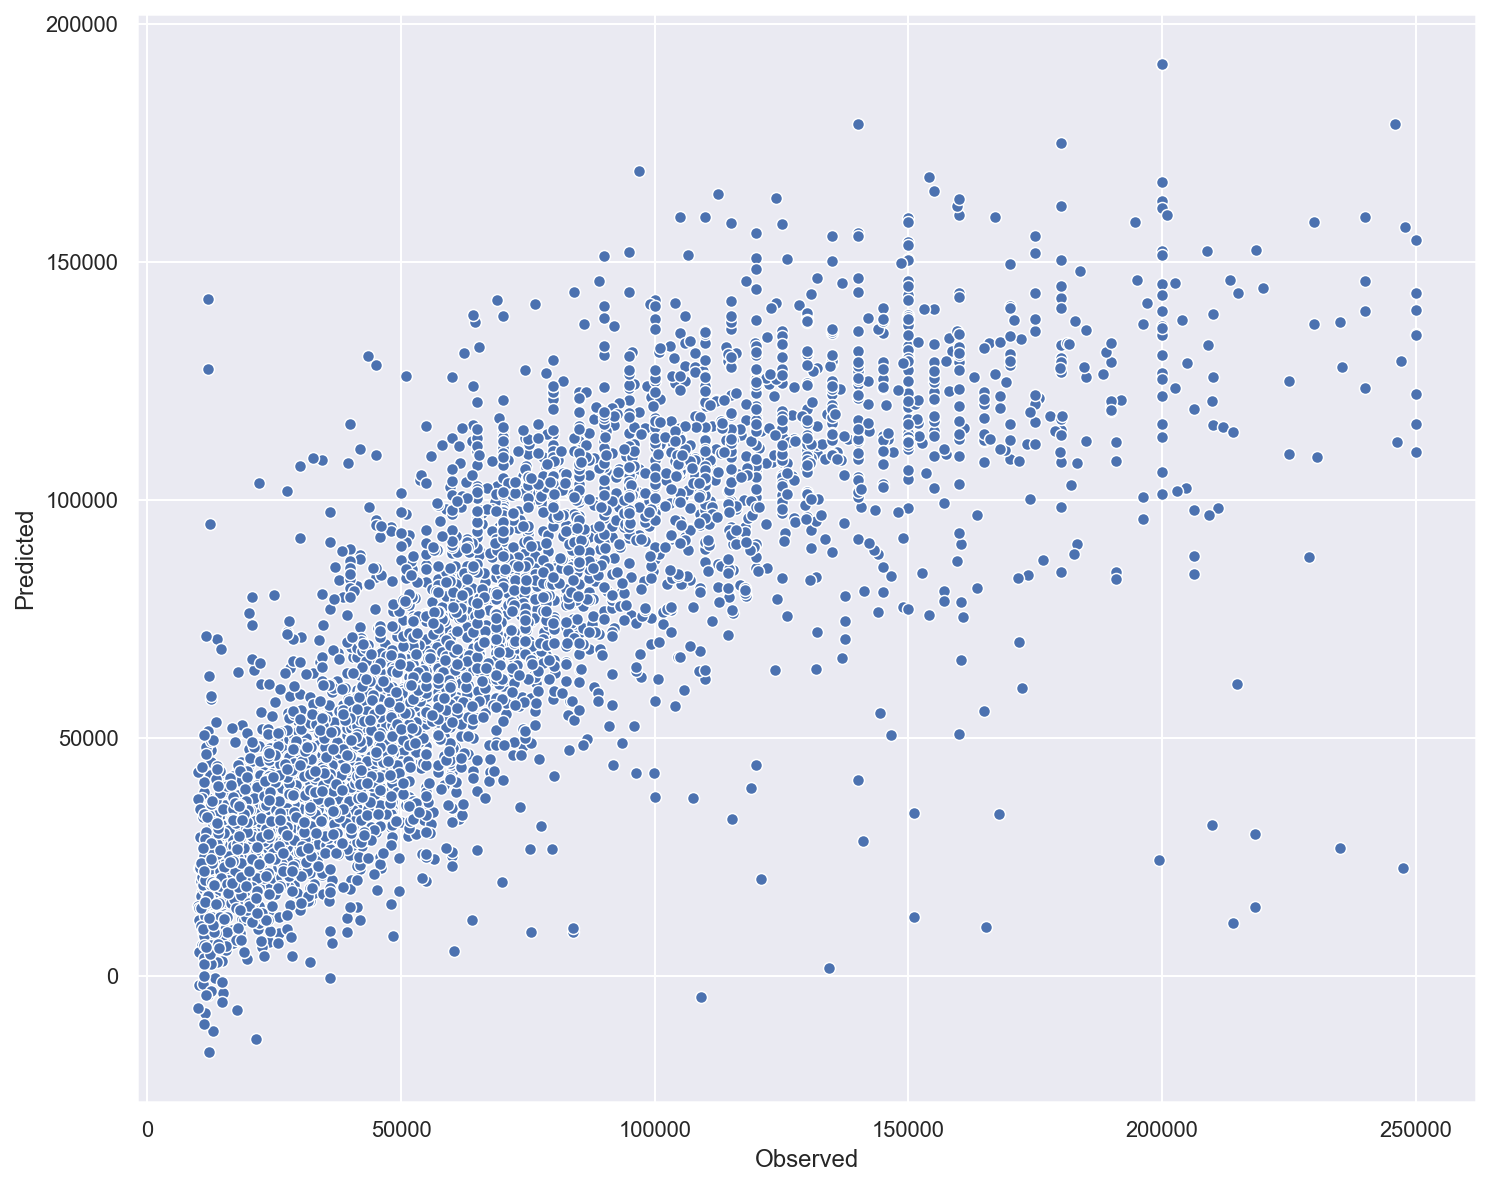

In [39]:
sns.scatterplot(x=lasso_outcomes['Observed'],y=lasso_outcomes['Predicted'])

In [40]:
# variables that the Lasso regression discarded 
lasso_removed = lasso_variables[lasso_variables['Coefficients']==0].index.tolist()
len(lasso_removed)

105

What happens if we run a lasso regression using the subset of 118 predictors?


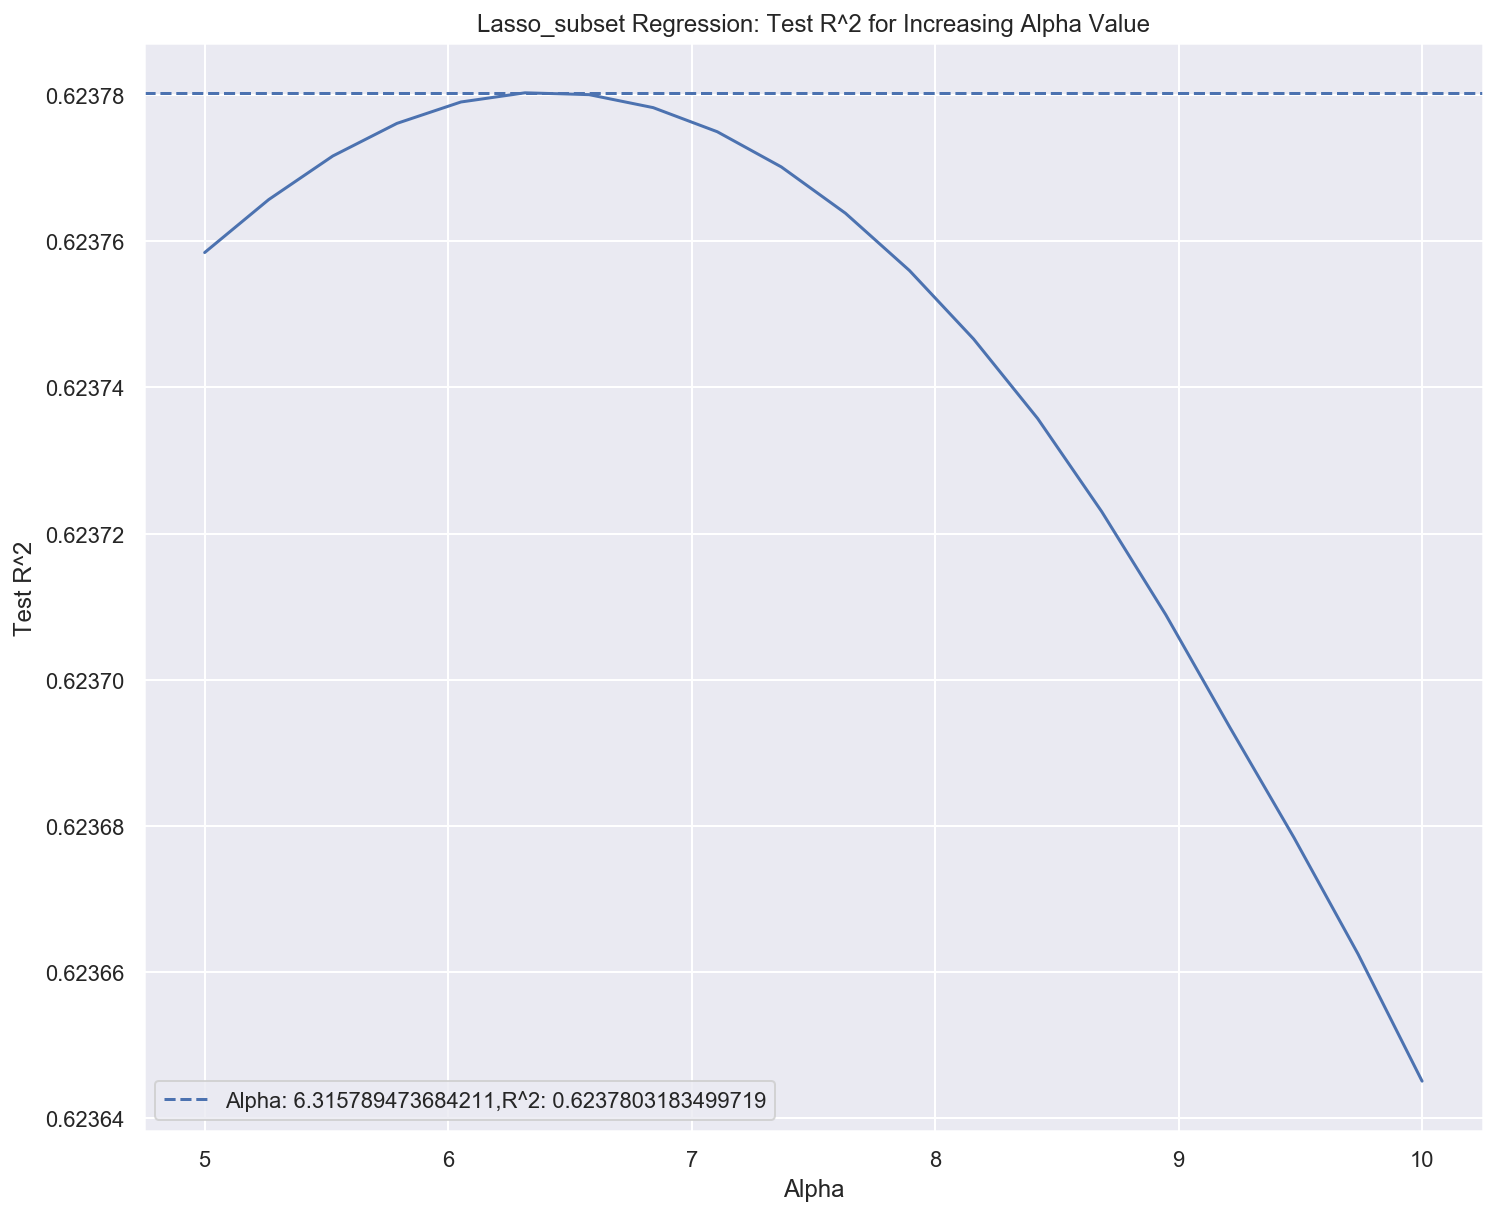

In [41]:
optimal_alpha(5,10,20,Lasso,'Lasso_subset',X_recursive,Y)

In [42]:
optimal_alphas

{'Lasso': 10.551724137931036, 'Lasso_subset': 6.315789473684211}

In [43]:
subset_lasso_variables,subset_lasso_performance,subset_lasso_outcomes = regularization(X_recursive,Y,optimal_alphas['Lasso_subset'],Lasso)

In [44]:
subset_lasso_performance

{'Train': 0.6231951853632705, 'Test': 0.6237803183499719}

In [58]:
subset_lasso_removed = subset_lasso_variables[subset_lasso_variables['Coefficients']==0].index.tolist()
len(subset_lasso_removed)

4

#### Ridge

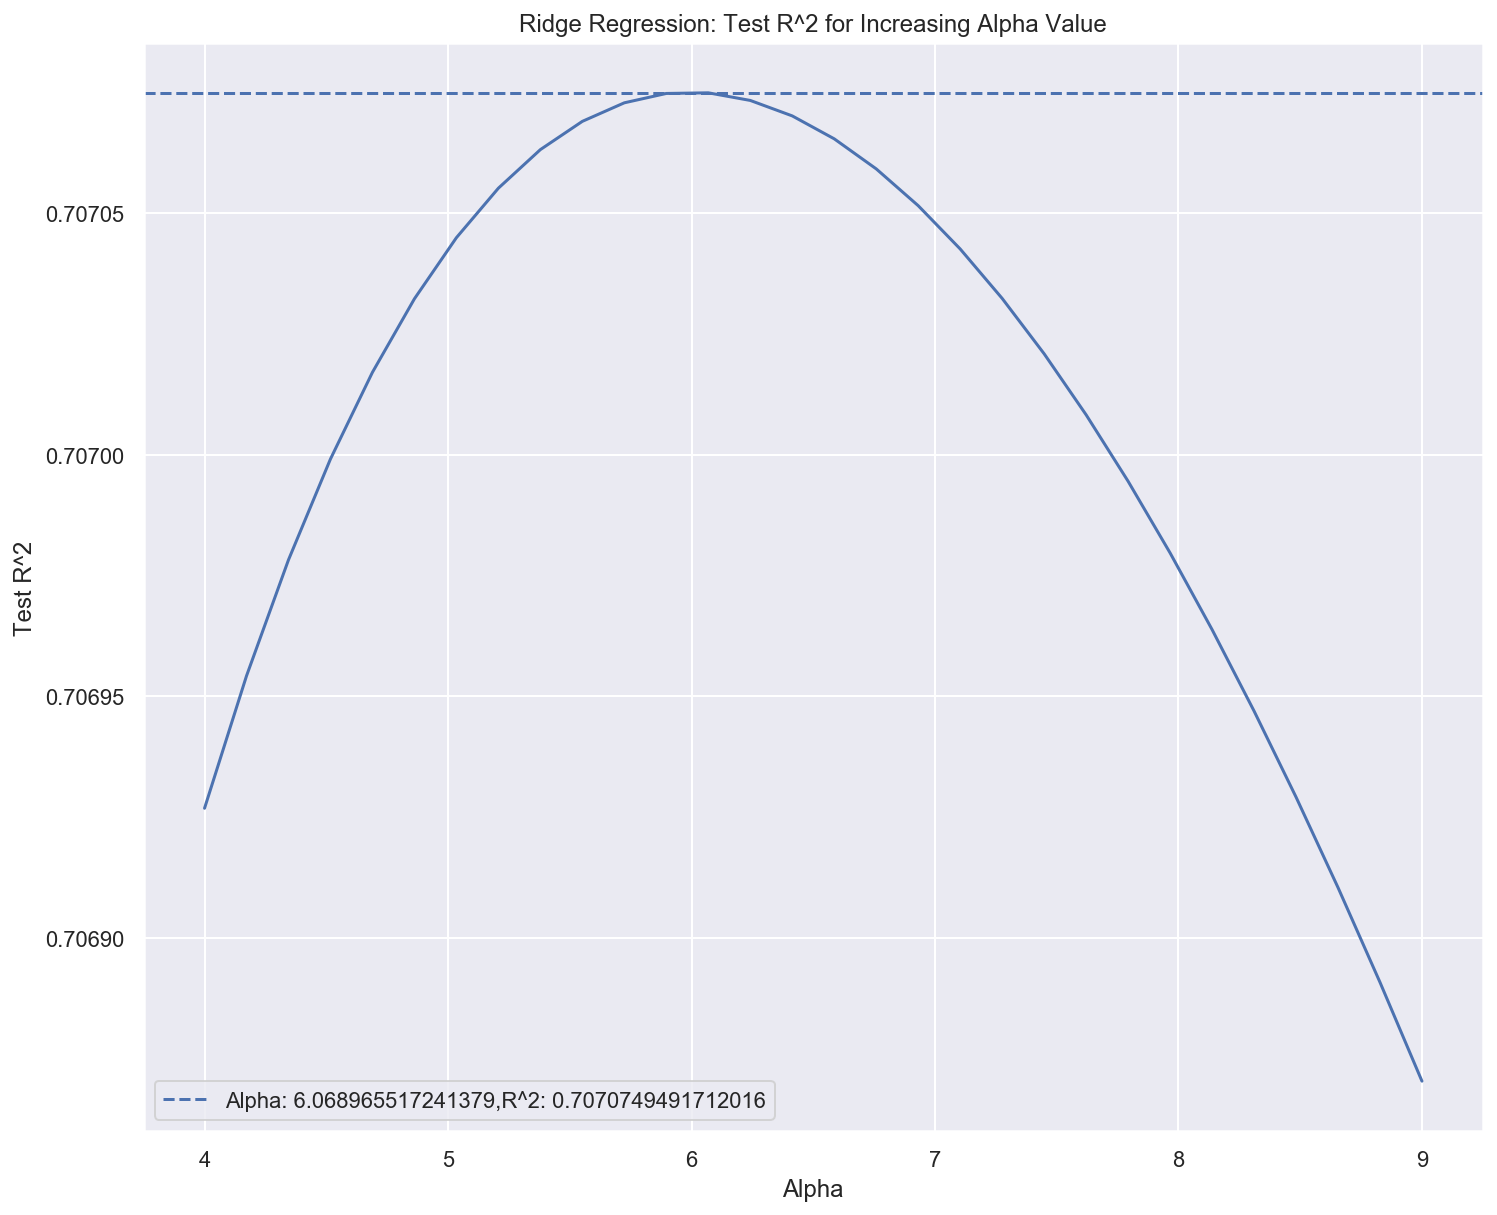

In [77]:
optimal_alpha(4,9,30,Ridge,'Ridge',X,np.log(Y))

In [78]:
optimal_alphas

{'Lasso': 10.551724137931036,
 'Lasso_subset': 6.315789473684211,
 'Ridge': 6.068965517241379,
 'Ridge_subset': 4.241379310344827}

In [79]:
ridge_variables,ridge_performance,ridge_outcomes = regularization(X,np.log(Y),optimal_alphas['Ridge'],Ridge)

In [80]:
ridge_variables.sort_values('Coefficients',ascending=False)

,Coefficients
Intercept,10.126902
Country_Israel,1.039919
Country_United States,0.887492
YearsCodePro,0.719583
Country_Switzerland,0.674497
Country_Denmark,0.656239
Country_Singapore,0.600361
Country_Hong Kong (S.A.R.),0.512422
Country_Canada,0.497709
Country_Norway,0.453103


In [81]:
ridge_outcomes

,Observed,Predicted,Residuals
67982,10.268131,10.037872,0.053019
50880,10.063052,10.128643,0.004302
15407,11.068434,11.179667,0.012373
23344,10.532096,10.519267,0.000165
21976,11.002100,10.742692,0.067292
...,...,...,...
59878,10.375489,10.412007,0.001334
3332,10.493799,10.644206,0.022622
15591,10.596635,11.001642,0.164031
35694,11.607435,10.982186,0.390937


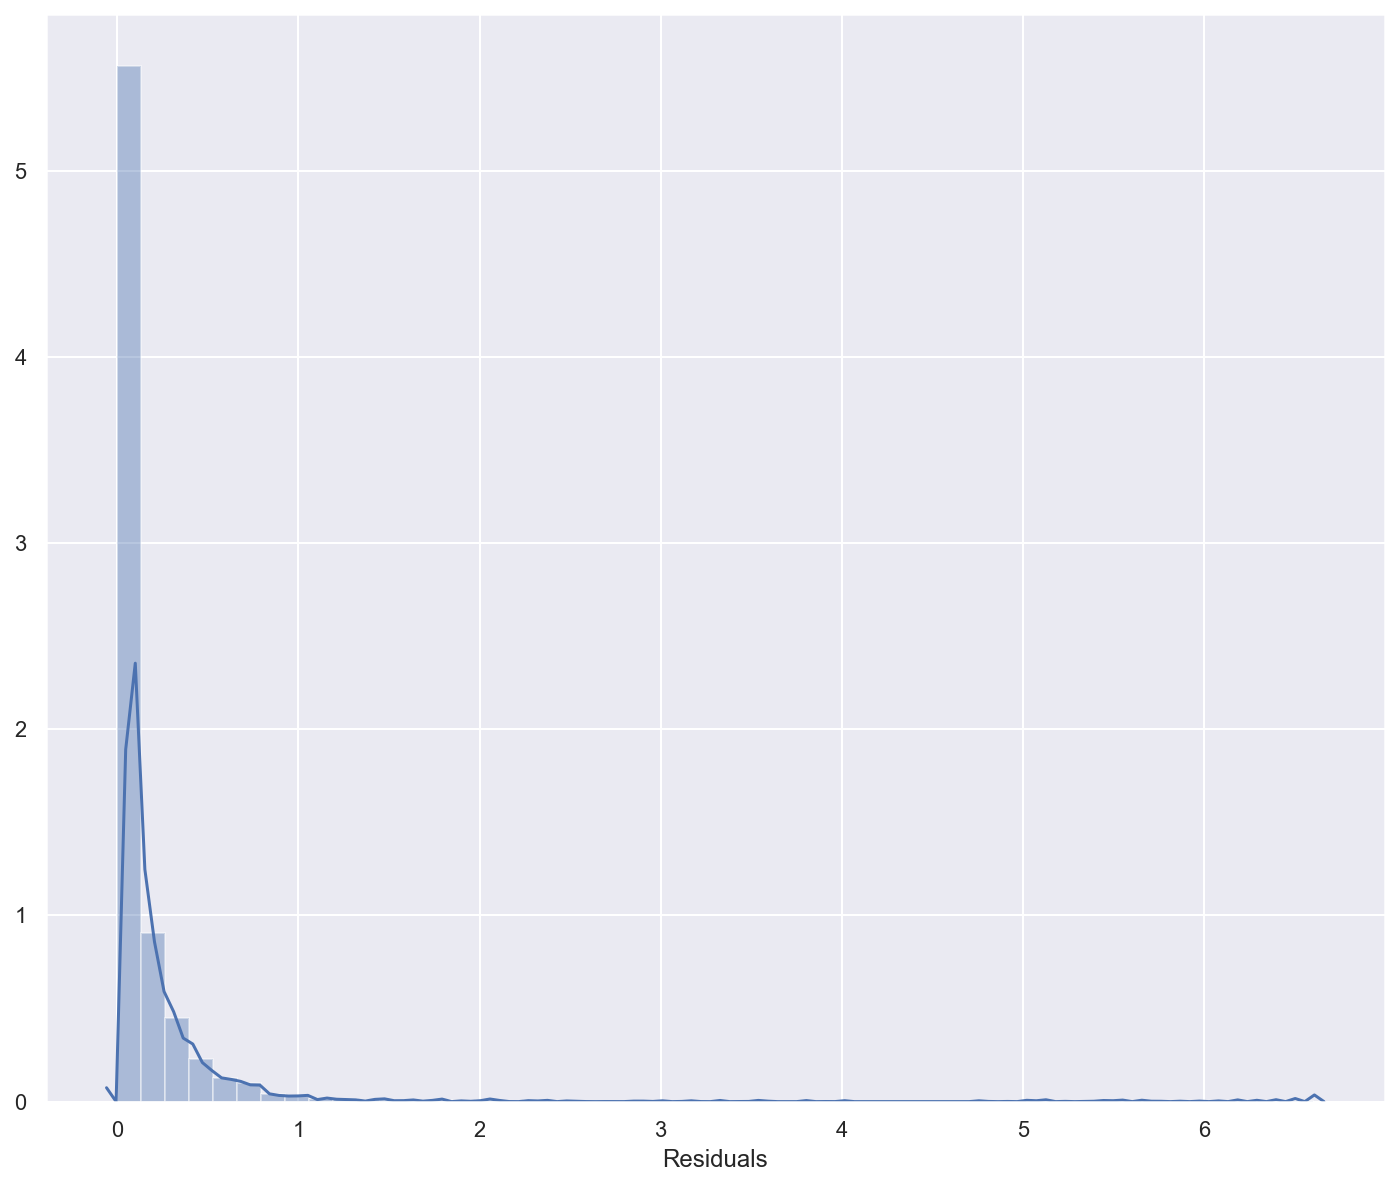

In [82]:
sns.distplot(ridge_outcomes['Residuals'])

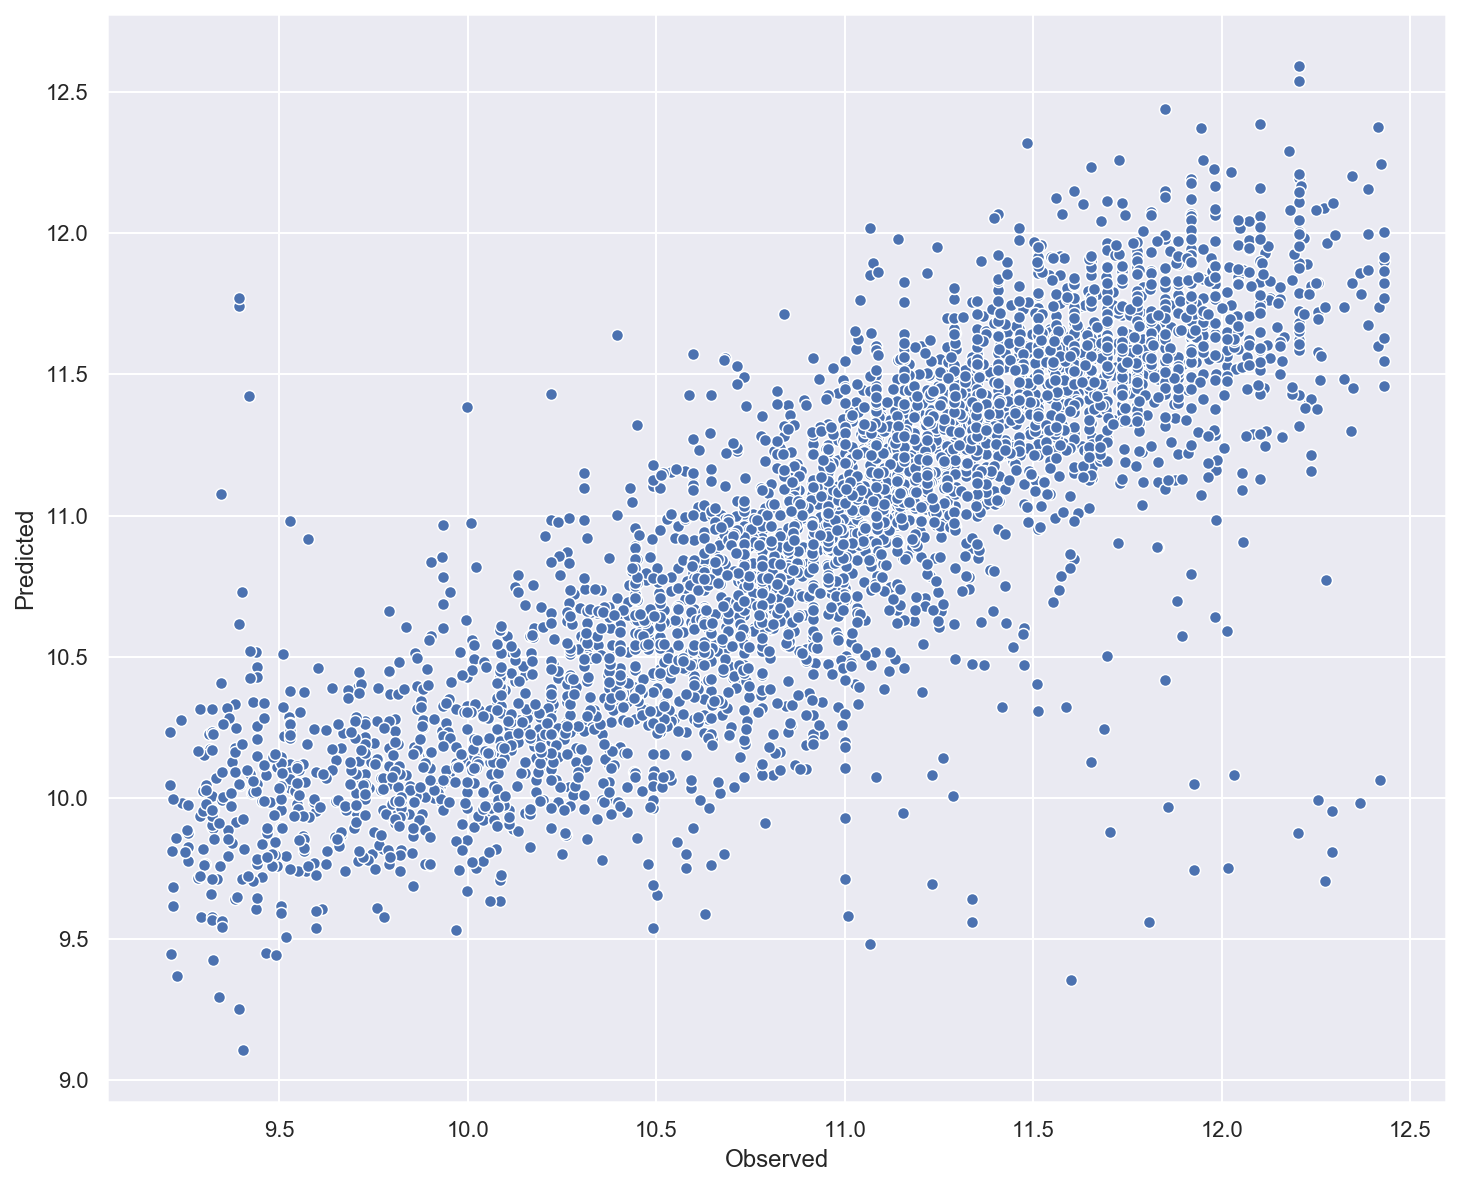

In [83]:
sns.scatterplot(x=ridge_outcomes['Observed'],y=ridge_outcomes['Predicted'])

In [84]:
ridge_performance

{'Train': 0.7136534428516692, 'Test': 0.7070749491712016}

Ridge regression did pretty well! Let's do it again with only our 118 subset. 

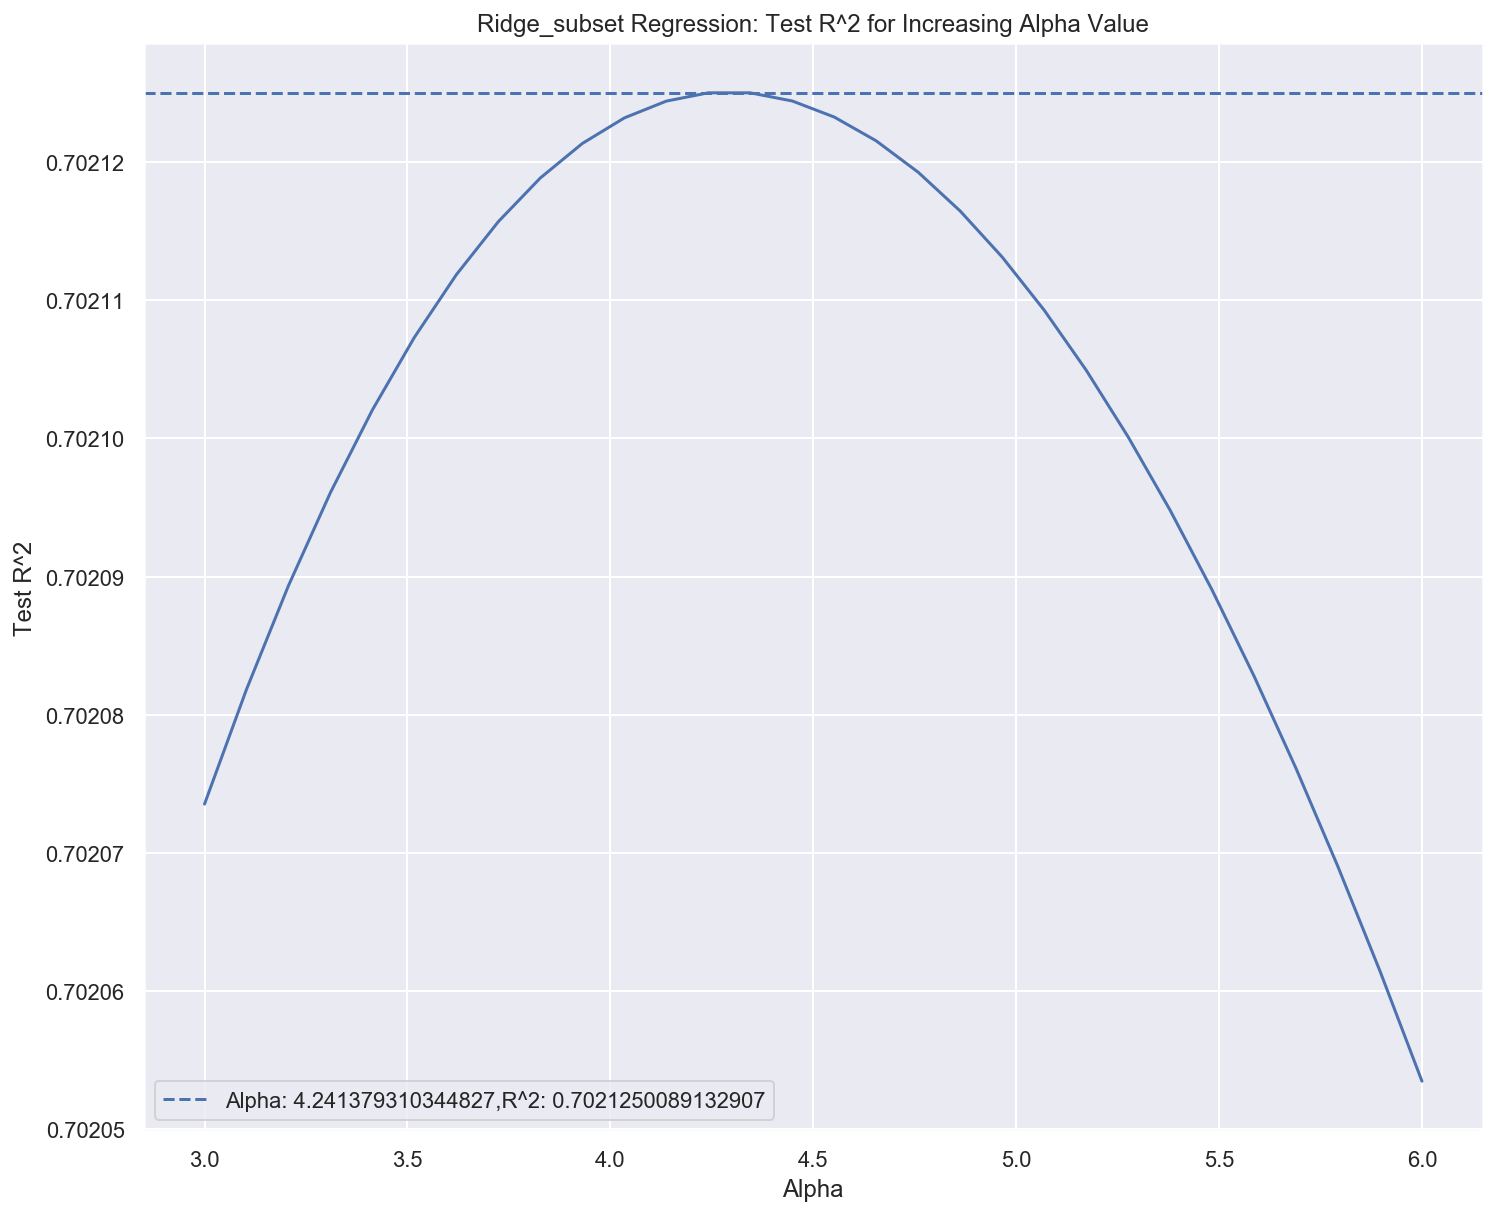

In [85]:
optimal_alpha(3,6,30,Ridge,'Ridge_subset',X_recursive,np.log(Y))

In [86]:
optimal_alphas

{'Lasso': 10.551724137931036,
 'Lasso_subset': 6.315789473684211,
 'Ridge': 6.068965517241379,
 'Ridge_subset': 4.241379310344827}

In [87]:
subset_ridge_variables,subset_ridge_performance,subset_ridge_outcomes = regularization(X_recursive,np.log(Y),optimal_alphas['Ridge_subset'],Ridge)

In [90]:
subset_ridge_performance

{'Train': 0.7030111019908774, 'Test': 0.7021250089132907}

In [93]:
ols_variables,ols_performance,ols_outcomes = regularization(X_recursive,np.log(Y),None,LinearRegression)

In [94]:
ols_performance

{'Train': 0.7033258234703852, 'Test': 0.7003340501443969}

When we us the orignal predictors that we had before elimating many of them with our recursive function, the R^2 for our test data is negative, showing that our initial OLS was drastically overfitting the data.

In [96]:
ols_overfit_variables, ols_overfit_performance,ols_overfit_outcomes = regularization(X,np.log(Y),None,LinearRegression)

In [97]:
ols_overfit_performance

{'Train': 0.716832012843369, 'Test': -2.5738464663756224e+16}

In [100]:
regularization(X_recursive,np.log(Y),optimal_alphas['Ridge_subset'],Ridge)[1]

{'Train': 0.7030111019908774, 'Test': 0.7021250089132907}

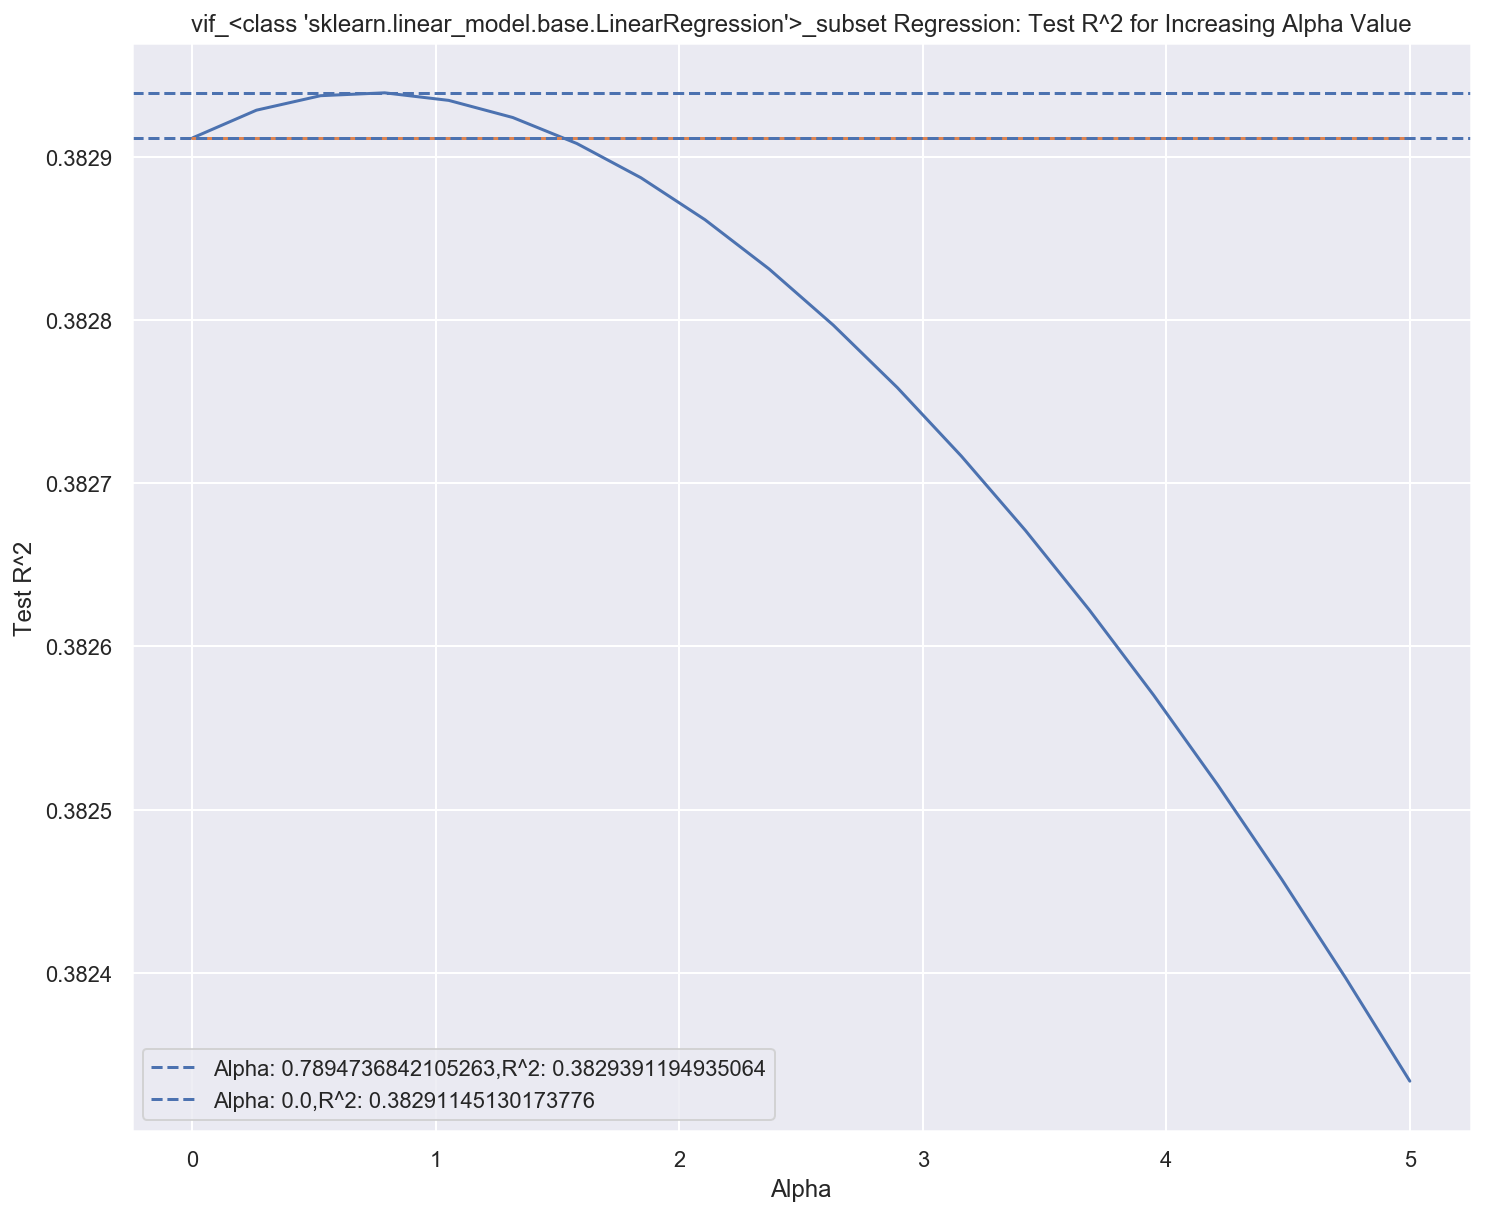

In [107]:
Models = [Ridge,LinearRegression]
temp = []
for model in Models:
    optimal_alpha(0,5,20,model,'vif_{}_subset'.format(model),X[x_keep],Y)
    temp.append(regularization(X[x_keep],np.log(Y),optimal_alphas['vif_{}_subset'.format(model)],model)[1])

In [108]:
temp

[{'Train': 0.43498897412315884, 'Test': 0.4391243547490742},
 {'Train': 0.43523489067500554, 'Test': 0.4388450257389851}]

### Additional Investigation

In [ ]:
def QQplot(outcomes):
    
    z= (outcomes['Observed']-outcomes['Observed'].mean())/np.std(ridge_outcomes['Observed'])
    stats.probplot(z, dist="norm", plot=plt)
    plt.title("Q-Q plot")
    plt.show()

In [ ]:
df[['ConvertedComp','YearsCodePro']].corr()

In [ ]:
df.groupby('Gender_Man').mean()[['ConvertedComp']]

In [ ]:
continents = [x for x in df.columns.tolist() if 'Continent' in x]
continents

dfs = []
for continent in continents:
    temp = df.groupby(continent).mean().iloc[[1]]
    temp.index = [continent]
    
    dfs.append(temp)

pd.concat(dfs,sort=False)

In [ ]:
temp = df[df['Continent_Africa']==1]
temp

Question: Which of our quantitative predictors are most correlated with our outcome variable (ConvertedComp)?


In [ ]:
corr = df.drop('Respondent',axis=1)[['ConvertedComp','Age','YearsCodePro','YearsCode','CodeRevHrs','learned_code','WorkWeekHrs']].corr()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
df.columns.tolist()

In [ ]:
x = np.log(df['ConvertedComp'])
x

In [ ]:
z= (x-x.mean())/np.std(x)
stats.probplot(z, dist="norm", plot=plt)
plt.title("Q-Q plot")
plt.show()

In [116]:
ridge_variables.sort_values('Coefficients',ascending=False).index.tolist()[1:21]

['Country_Israel',
 'Country_United States',
 'YearsCodePro',
 'Country_Switzerland',
 'Country_Denmark',
 'Country_Singapore',
 'Country_Hong Kong (S.A.R.)',
 'Country_Canada',
 'Country_Norway',
 'Country_Japan',
 'Country_United Arab Emirates',
 'Country_Saudi Arabia',
 'Country_Iceland',
 'WorkWeekHrs',
 'Country_South Korea',
 'Continent_Oceania Australia',
 'Country_Finland',
 'Country_Somalia',
 'Country_Germany',
 'Country_Cyprus']

In [117]:
ridge_variables.sort_values('Coefficients',ascending=True).index.tolist()[1:21]

['Country_Egypt',
 'Country_Sri Lanka',
 'Country_Greece',
 'Country_Nigeria',
 'Country_Nepal',
 'Country_India',
 'Country_Russian Federation',
 'Country_Honduras',
 'Country_Bangladesh',
 'Country_Croatia',
 'Employment_Employed part-time',
 'Country_Indonesia',
 'Country_Portugal',
 'Country_Malaysia',
 'Country_Ukraine',
 'Country_Mexico',
 'Country_Yemen',
 'Country_Hungary',
 'Country_Bosnia and Herzegovina',
 'Country_Viet Nam']

In [182]:
countries = [x for x in X_recursive.columns.tolist() if 'Country' in x]

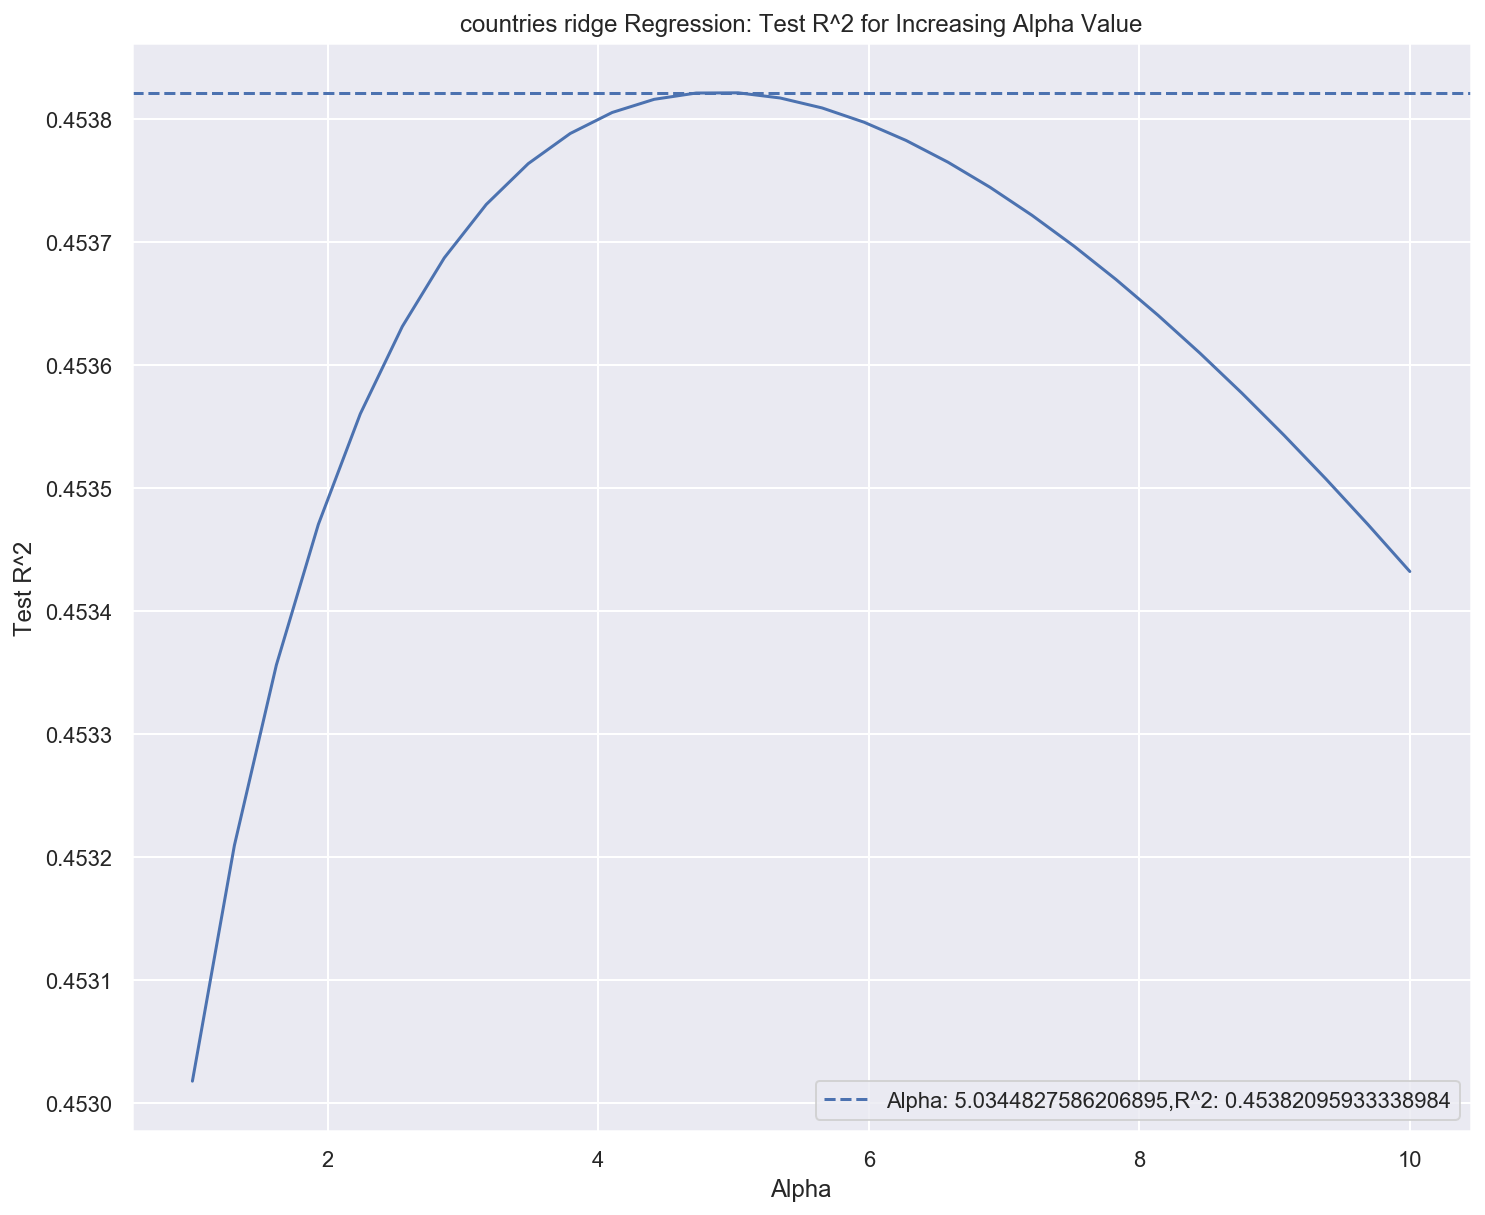

In [121]:
optimal_alpha(1,10,30,Ridge,'countries ridge',X[countries],Y)

In [206]:
x_keep

['WorkWeekHrs',
 'YearsCode',
 'CodeRevHrs',
 'YearsCodePro',
 'learned_code',
 'Bash/Shell/PowerShell',
 'C#',
 'F#',
 'Go',
 'HTML/CSS',
 'Other(s):',
 'PHP',
 'Ruby',
 'Scala',
 'TypeScript',
 'VBA',
 'East Asian',
 'Native American, Pacific Islander, or Indigenous Australian',
 'South Asian',
 'White or of European descent',
 'OrgSize_1,000 to 4,999 employees',
 'OrgSize_10 to 19 employees',
 'OrgSize_10,000 or more employees',
 'OrgSize_2-9 employees',
 'OrgSize_20 to 99 employees',
 'OrgSize_5,000 to 9,999 employees',
 'OrgSize_Just me - I am a freelancer, sole proprietor, etc.',
 'Country_Australia',
 'Country_Austria',
 'Country_Belarus',
 'Country_Belgium',
 'Country_Bulgaria',
 'Country_Canada',
 'Country_Croatia',
 'Country_Cyprus',
 'Country_Czech Republic',
 'Country_Denmark',
 'Country_Egypt',
 'Country_Finland',
 'Country_Germany',
 'Country_Greece',
 'Country_Hong Kong (S.A.R.)',
 'Country_Hungary',
 'Country_Iceland',
 'Country_India',
 'Country_Indonesia',
 'Country_I

In [205]:
X[x_keep]

,WorkWeekHrs,YearsCode,CodeRevHrs,YearsCodePro,learned_code,Bash/Shell/PowerShell,C#,F#,Go,HTML/CSS,...,SOVisitFreq_Daily or almost daily,SOVisitFreq_Less than once per month or monthly,SOVisitFreq_Multiple times per day,SOPartFreq_Daily or almost daily,SOPartFreq_I have never participated in Q&A on Stack Overflow,FizzBuzz_Yes,Continent_Africa,Continent_Europe,Continent_Oceania Australia,Gender_Woman:Dependents_Yes
13,40.0,13,4.0,2,18.0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0.0
16,45.0,5,5.0,2,24.0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0.0
18,8.0,14,3.0,13,17.0,0,1,0,0,1,...,1,0,0,0,1,0,0,0,0,0.0
22,40.0,3,8.0,1,19.0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0.0
28,40.0,4,2.0,2,28.0,1,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88296,40.0,12,4.0,8,16.0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0.0
88298,40.0,14,3.0,11,20.0,0,0,0,0,1,...,1,0,0,0,1,1,0,0,0,0.0
88301,36.0,8,4.0,6,19.0,1,1,0,0,1,...,0,0,1,0,1,1,0,0,0,0.0
88323,40.0,8,3.0,2,15.0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0


In [210]:
poly_2 = PolynomialFeatures(degree=2, interaction_only=False)
df_poly= pd.DataFrame(poly_2.fit_transform(X_recursive[x_keep]), columns=poly_2.get_feature_names(X_recursive[x_keep].columns))
df_poly = df_poly.drop(columns=df_poly[[x for x in df_poly.columns.tolist() if ':' in x]].columns.tolist())


In [211]:
df_poly

,1,WorkWeekHrs,CodeRevHrs,learned_code,Bash/Shell/PowerShell,C#,F#,Go,HTML/CSS,PHP,...,SOPartFreq_I have never participated in Q&A on Stack Overflow^2,SOPartFreq_I have never participated in Q&A on Stack Overflow FizzBuzz_Yes,SOPartFreq_I have never participated in Q&A on Stack Overflow Continent_Africa,SOPartFreq_I have never participated in Q&A on Stack Overflow Continent_Oceania Australia,FizzBuzz_Yes^2,FizzBuzz_Yes Continent_Africa,FizzBuzz_Yes Continent_Oceania Australia,Continent_Africa^2,Continent_Africa Continent_Oceania Australia,Continent_Oceania Australia^2
0,1.0,40.0,4.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,45.0,5.0,24.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,8.0,3.0,17.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,40.0,8.0,19.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,40.0,2.0,28.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18641,1.0,40.0,4.0,16.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18642,1.0,40.0,3.0,20.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18643,1.0,36.0,4.0,19.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18644,1.0,40.0,3.0,15.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
Y.shape

(18646,)

In [200]:
df_poly.shape

(18646, 6786)

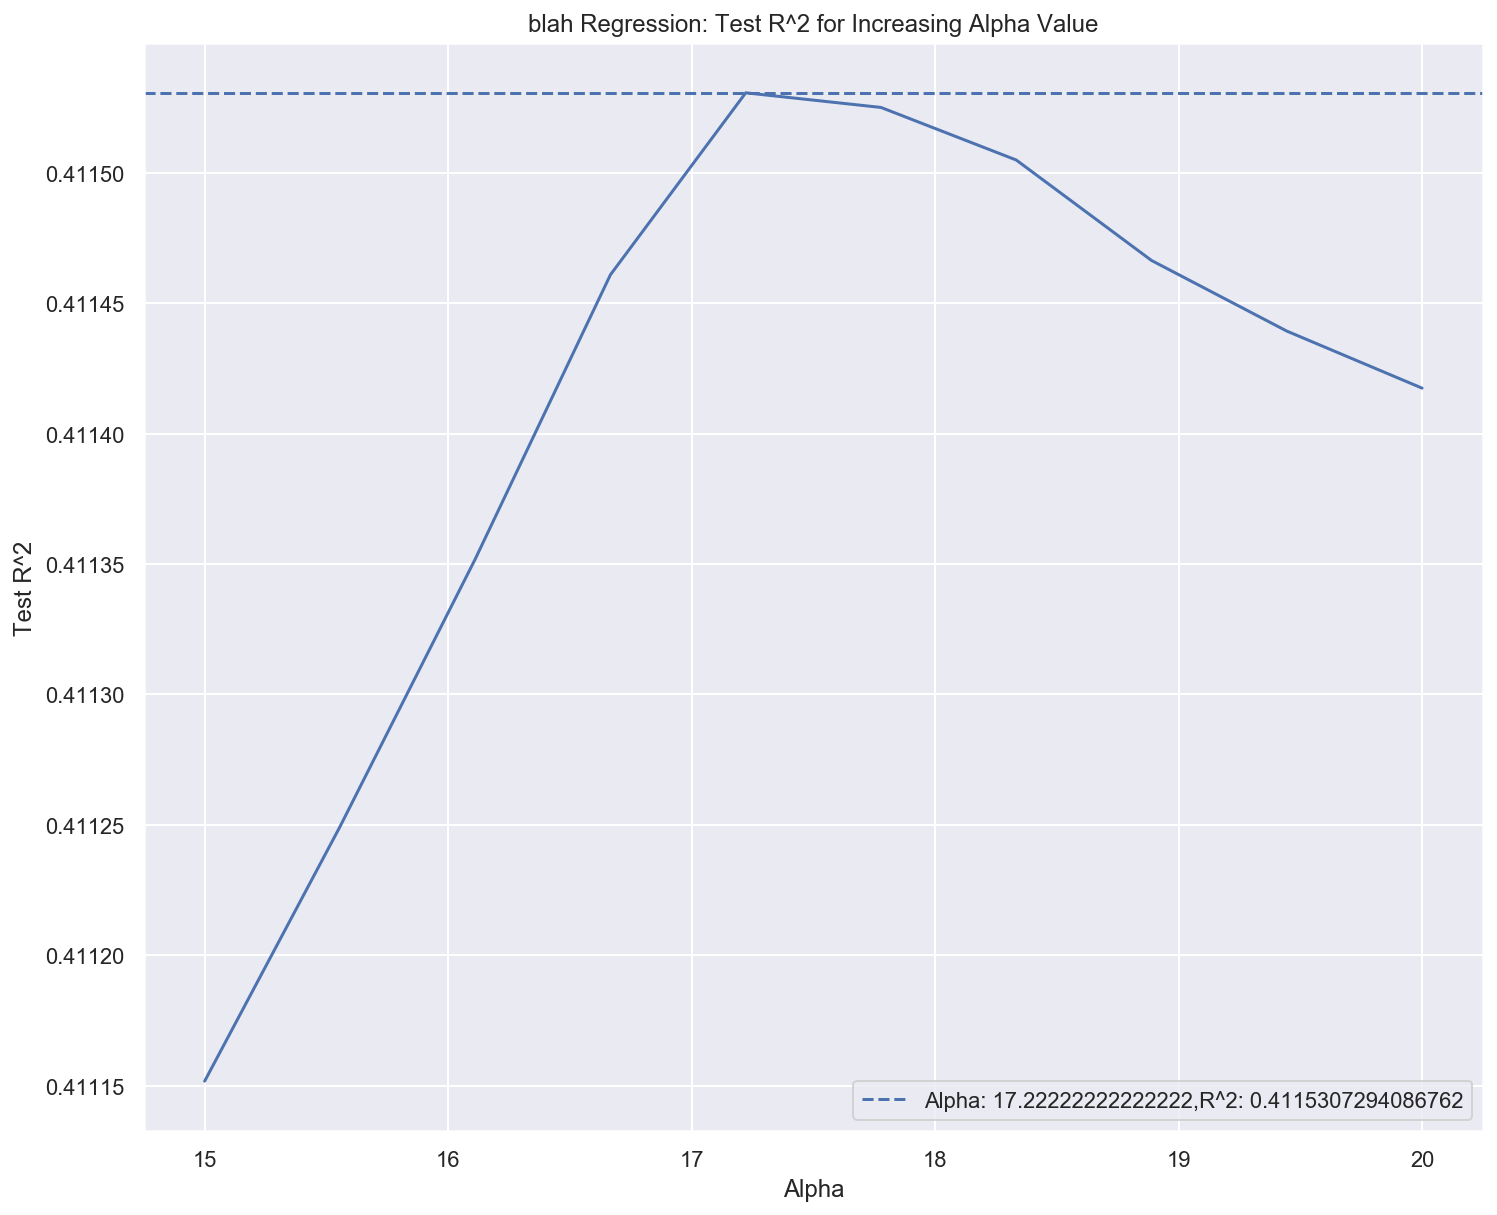

In [217]:
optimal_alpha(15,20,10,Lasso,'blah',df_poly,Y)